# Twitter Sentiment Analysis and Topic modeling

In [3]:
!pip install lime
!pip install tensorflow

In [4]:
# importing libraries

import pandas as pd
import seaborn as sns
sns.color_palette("viridis", as_cmap=True)
import numpy as np

import re, nltk
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/mauriciosotogomez/BABD2022/main/Lab_11_NLP_Case/Tweets.csv')
print(df.shape)
df.sample(10)

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
10531,569220920218296320,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,Marci_DZ,NaN,0,@USAirways now what? You Cancelled Flightled m...,NaN,2015-02-21 11:43:37 -0800,NaN,Eastern Time (US & Canada)
10734,568929010966765568,negative,1.0000,Customer Service Issue,0.6885,US Airways,NaN,scottsalkin,NaN,0,@USAirways your team was just terrifyingly rud...,NaN,2015-02-20 16:23:41 -0800,San Francisco & Scottsdale,Pacific Time (US & Canada)
9197,570073507465469952,negative,1.0000,Customer Service Issue,0.6813,US Airways,NaN,worldwideweg,NaN,0,@USAirways - No live person to speak with all ...,NaN,2015-02-23 20:11:30 -0800,NaN,NaN
11390,568151138421207040,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,as4438,NaN,0,@USAirways stop Cancelled Flighting flights ov...,NaN,2015-02-18 12:52:41 -0800,NaN,NaN
10872,568809407120855041,negative,1.0000,Late Flight,1.0000,US Airways,NaN,G_Will_Eye_Am,NaN,0,@USAirways delayed I'm charlotte big surprise,NaN,2015-02-20 08:28:25 -0800,NaN,NaN
7541,569538135916351489,positive,1.0000,NaN,NaN,Delta,NaN,2littlebirds,NaN,0,“@JetBlue: @2littlebirds Beautiful shot.. Than...,"[38.69255098, -121.58854512]",2015-02-22 08:44:07 -0800,LA CA USA,Pacific Time (US & Canada)
9579,569867947130421249,neutral,0.6629,NaN,0.0000,US Airways,NaN,DonIrvine,NaN,0,@USAirways 4473. She just called to say it's ...,NaN,2015-02-23 06:34:40 -0800,Washington DC,Eastern Time (US & Canada)
11393,568148808993013761,negative,1.0000,Lost Luggage,0.6635,US Airways,NaN,tannapistolis,NaN,0,@USAirways What's the point of a baggage claim...,NaN,2015-02-18 12:43:26 -0800,NaN,Eastern Time (US & Canada)
6572,567774100299739138,positive,1.0000,NaN,NaN,Southwest,NaN,smckenna719,NaN,0,@SouthwestAir - just talking to customer servi...,NaN,2015-02-17 11:54:28 -0800,Washington DC,NaN
7524,569543615862722561,positive,1.0000,NaN,NaN,Delta,NaN,KShay1985,NaN,0,@JetBlue thank you. We are finally at the gate.,NaN,2015-02-22 09:05:54 -0800,"New York City, NY",NaN


In [6]:
print(df['text'][42])
print()
print(df['text'][222])

@VirginAmerica plz help me win my bid upgrade for my flight 2/27 LAX---&gt;SEA!!!  🍷👍💺✈️

@VirginAmerica when are you putting some great deals from PDX to LAS or from LAS to PDX show me your love! http://t.co/enIQg0buzj


In [7]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [9]:
df.shape

(14640, 15)

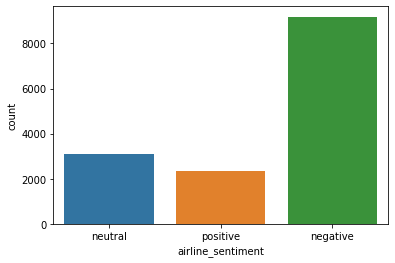

In [10]:
# Unique values of sentiment plot

ax = sns.countplot(x="airline_sentiment", data=df)

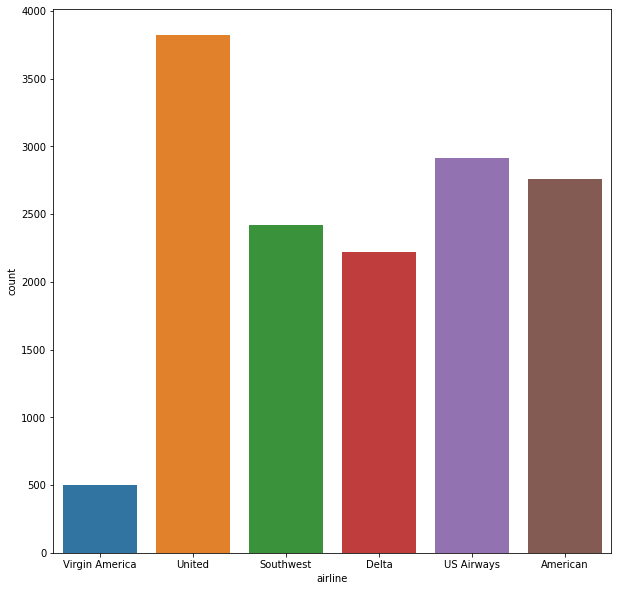

In [11]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

### Text cleaning

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['get','hour','http','co'])

def clean_text(text):
  text = re.sub("&[a-z]*;", " ",text)                                           # html tags such as &gt; 
  text = re.sub("[^a-zA-Z]", " ",text)                                          # keep only letters
  text = text.lower()                                                           # lower case                                              
  # Remove stop_word
  words = word_tokenize(text)
  new_text = ""
  for i,w in enumerate(words):
    if i == 0:                                                                  # first token is always airline name
      continue
    if w == 'flightled':
      w = 'flight'
    if w not in stop_words and len(w) > 1:
      new_text = new_text + " " + w
  return new_text
  #return ' '.join([word for word in text.split() if word.lower() not in stopwords.words('english')])                             

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from nltk import word_tokenize, pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def lemmatize_tag(text):
    lemma=[]
    for i,j in pos_tag(word_tokenize(text)) :
        p=j[0].lower()
        lm = ''
        if p in ['j','n','v']:
            if p == 'j':
                p = 'a'
            lm = wnl.lemmatize(i,p)
            
        else :
            lm = wnl.lemmatize(i)
        if len(lm) > 1:
          lemma.append(lm)
    return ' '.join(lemma)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
i = 5

print("BEFORE:        "+df['text'][i])
print("CLEAN:         "+clean_text(df['text'][i]))
print("CLEAN & LEMM:  "+lemmatize_tag(clean_text(df['text'][i])))

BEFORE:        @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
CLEAN:          seriously would pay flight seats playing really bad thing flying va
CLEAN & LEMM:  seriously would pay flight seat play really bad thing fly va


In [14]:
print(df.shape)

# removing neutral tweets
df = df[df['airline_sentiment']!='neutral']
print(df.shape)

# positive negative codification
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)

# removing neutral tweets
df['cleaned_tweet'] = df['text'].apply(clean_text)
df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize_tag)

# remove rows with empty clean tweets
df = df[df['cleaned_tweet'].apply(len)>0]

print(df.shape)
df.head()


(14640, 15)
(11541, 15)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(11529, 16)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercial experience tacky
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),seriously would pay flight seat play really ba...
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),yes nearly every time fly vx ear worm go away


In [15]:
df['airline_sentiment'].unique()

array([1, 0])

# Custom sentiment model


In [34]:
def check_scores(clf, X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]

  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print()
  print("Train f1: ", f1_score(y_train, predicted_class_train))
  print("Test f1: ", f1_score(y_test, predicted_class))
  print()
  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  
  fig, ax1 = plt.subplots(1,1)

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  fpr, tpr, _ = roc_curve(y_test, test_probs)
  ax1.plot(fpr, tpr)
  ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                      param_grid = parameters,
                      cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model




### SVM

In [20]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


In [21]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,0.3,1,3,10],
    "kernel":['linear']} 

svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Best parameters are: 
{'C': 3, 'kernel': 'linear'}


Train confusion matrix is: 
[[6838   32]
 [  95 1681]]

Test confusion matrix is: 
[[2214   85]
 [ 168  416]]

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      2299
           1       0.83      0.71      0.77       584

    accuracy                           0.91      2883
   macro avg       0.88      0.84      0.86      2883
weighted avg       0.91      0.91      0.91      2883



Train f1:  0.9635998853539697
Test f1:  0.7668202764976959

Train accuracy score:  0.9853111265325005
Test accuracy score:  0.912244190079778

Train ROC-AUC score:  0.9952404369434937
Test ROC-AUC score:  0.9406103457727302


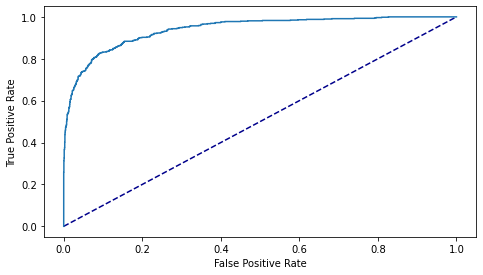

In [22]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

### Using Multinomial Naive Bayes

Train confusion matrix is: 
[[6868    2]
 [1144  632]]

Test confusion matrix is: 
[[2296    3]
 [ 455  129]]

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2299
           1       0.98      0.22      0.36       584

    accuracy                           0.84      2883
   macro avg       0.91      0.61      0.63      2883
weighted avg       0.86      0.84      0.80      2883



Train f1:  0.5244813278008298
Test f1:  0.36033519553072624

Train accuracy score:  0.8674531575294934
Test accuracy score:  0.8411377037807839

Train ROC-AUC score:  0.964453427226353
Test ROC-AUC score:  0.9221884738450907


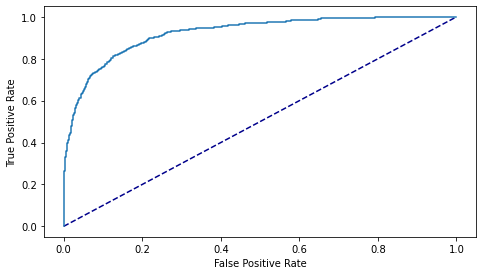

In [23]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)


Tends to predict everything as a negative

### Adaboost

In [25]:
params = {'n_estimators': [100, 200, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Best parameters are: 
{'learning_rate': 1.0, 'n_estimators': 200}


Train confusion matrix is: 
[[6709  161]
 [ 496 1280]]

Test confusion matrix is: 
[[2192  107]
 [ 232  352]]

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2299
           1       0.77      0.60      0.67       584

    accuracy                           0.88      2883
   macro avg       0.84      0.78      0.80      2883
weighted avg       0.88      0.88      0.88      2883



Train f1:  0.7957724588125583
Test f1:  0.6749760306807286

Train accuracy score:  0.9240111034004164
Test accuracy score:  0.882414151925078

Train ROC-AUC score:  0.9689236316010332
Test ROC-AUC score:  0.9011295858234969


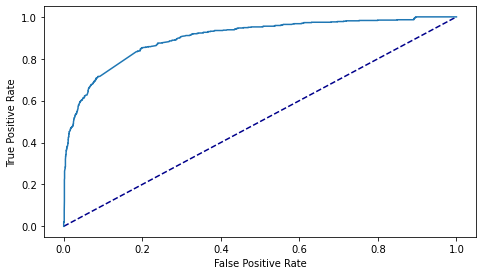

In [26]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)


### Random Forest

Train confusion matrix is: 
[[6870    0]
 [ 293 1483]]

Test confusion matrix is: 
[[2179  120]
 [ 227  357]]

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2299
           1       0.75      0.61      0.67       584

    accuracy                           0.88      2883
   macro avg       0.83      0.78      0.80      2883
weighted avg       0.87      0.88      0.87      2883



Train f1:  0.910095121202823
Test f1:  0.6729500471253533

Train accuracy score:  0.9661114966458478
Test accuracy score:  0.8796392646548734

Train ROC-AUC score:  0.9967324311210773
Test ROC-AUC score:  0.8923195463185305


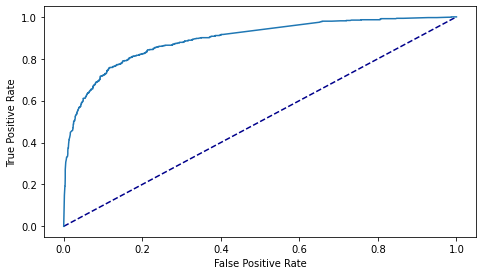

In [39]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0,max_features=0.3, max_depth=100).fit(x_train, y_train), x_train,x_test,y_train,y_test)


### LSTM


In [98]:
corpus = [df['cleaned_tweet'][i] for i in df.index]
print(df['cleaned_tweet'].iloc[0])

# kera's function for tokenizing and one encoding
voc_size=5000
onehot_enc=[one_hot(words,voc_size) for words in corpus] 
print(onehot_enc[0])

# create sequences of the same length
max_sent_length=max([len(i) for i in corpus])
embedded_docs=pad_sequences(onehot_enc,padding='post',maxlen=max_sent_length)
print(embedded_docs[0])
print(len(embedded_docs[0]))

model=Sequential()
# Embedding with:
# - a vocabulary size of voc_size
# - condensing info in a vector of size embedding_vector_features
# - accounting for information in sequence, length = max_sent_length
embedding_vector_features=40
emb_layer = Embedding(input_dim=voc_size, output_dim=embedding_vector_features, input_length=max_sent_length)
model.add(emb_layer)
model.add(Dropout(0.3))

model.add(LSTM(100))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
print(X_final.shape,y_final.shape)

plus added commercial experience tacky
[768, 4324, 697, 3341, 1494]
[ 768 4324  697 3341 1494    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(11529, 120) (11529,)


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, random_state=42)
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


Epoch 1/10
136/136 [==============================] - 27s 202ms/step - loss: 0.5116 - accuracy: 0.7946 - val_loss: 0.5000 - val_accuracy: 0.8003
Epoch 2/10
136/136 [==============================] - 22s 165ms/step - loss: 0.5098 - accuracy: 0.7946 - val_loss: 0.5010 - val_accuracy: 0.8003
Epoch 3/10
136/136 [==============================] - 23s 172ms/step - loss: 0.5103 - accuracy: 0.7946 - val_loss: 0.5016 - val_accuracy: 0.8003
Epoch 4/10
136/136 [==============================] - 31s 227ms/step - loss: 0.5105 - accuracy: 0.7946 - val_loss: 0.5001 - val_accuracy: 0.8003
Epoch 5/10
136/136 [==============================] - 23s 171ms/step - loss: 0.5094 - accuracy: 0.7946 - val_loss: 0.5015 - val_accuracy: 0.8003
Epoch 6/10
136/136 [==============================] - 22s 165ms/step - loss: 0.5093 - accuracy: 0.7946 - val_loss: 0.5019 - val_accuracy: 0.8003
Epoch 7/10
136/136 [==============================] - 23s 166ms/step - loss: 0.5104 - accuracy: 0.7946 - val_loss: 0.5017 - val_ac

In [102]:
print(emb_layer.get_weights()[0])

[[-0.0201618  -0.04950611  0.04942426 ...  0.00620472 -0.0414826
   0.04559207]
 [-0.02103245  0.03102117 -0.00177242 ... -0.03538524 -0.03699581
   0.0131152 ]
 [ 0.02524066  0.0159471  -0.01712537 ...  0.04009491 -0.01630973
   0.01992478]
 ...
 [ 0.03338911 -0.0097317  -0.02181251 ... -0.03870877 -0.00817182
  -0.04314892]
 [-0.03053494 -0.04574876 -0.03089695 ... -0.02005493 -0.0206831
  -0.04778351]
 [-0.04517946  0.02200583  0.00873969 ...  0.02156997  0.02574045
   0.03360526]]


In [ ]:
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")

In [ ]:
test_acc_lstm = accuracy_score(y_test,y_test_pred)
train_acc_lstm = accuracy_score(y_train,y_train_pred)
test_roc_lstm = roc_auc_score(y_test,y_test_pred)
train_roc_lstm = roc_auc_score(y_train,y_train_pred)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Final Results
 </h1>
</div>



In [ ]:
data = [('SVM', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc),
('MultinomialNB',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc  ),
('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
('AdaBoost',ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc),
('LSTM',train_acc_lstm, test_acc_lstm, train_roc_lstm, test_roc_lstm )]

Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train AUC', 'Test AUC'])
Scores_.set_index('Model Name', inplace = True)

Scores_

# Topic modeling
Why do people have a bad sentiment?

In [40]:
df_neg = df[df['airline_sentiment']==0]
df_neg.shape

(9169, 16)

In [81]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim import matutils, models
from gensim.corpora import Dictionary
import scipy.sparse

def prepare_corpus(doc_clean):
  # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
  #dictionary = corpora.Dictionary(doc_clean)
  # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
  #corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
  #tfidf = TfidfModel(corpus) ##ngram_range=(1,1),min_df=3
  #corpus_tfidf = tfidf[corpus]

  cv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), min_df=3)
  data_cv = cv.fit_transform(df_neg.cleaned_tweet)
  data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names_out())
  data.index = df_neg.index
  tdm = data.transpose()
  sparse_counts = scipy.sparse.csr_matrix(tdm)
  corpus = matutils.Sparse2Corpus(sparse_counts)

  #d = corpora.Dictionary()
  id2word = dict((v, k) for k, v in cv.vocabulary_.items())
  #d.id2token = dict((v, k) for k, v in cv.vocabulary_.items())
  #d.id2token = id2word

  gensim_dict = Dictionary.from_corpus(corpus, id2word=id2word)

  return gensim_dict,corpus

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

print(df_neg['cleaned_tweet'].iloc[0])
dictionary, corpus = prepare_corpus(df_neg.cleaned_tweet.apply(word_tokenize))
print(corpus[0])
print(len(dictionary))


really aggressive blast obnoxious entertainment guest face little recourse
[(52, 0.4093206587489333), (249, 0.3988670588001145), (751, 0.3339233641376385), (818, 0.3388591853818621), (1014, 0.3988670588001145), (1321, 0.2959337381018054), (1828, 0.21910119420585708), (1845, 0.3903258457310167)]
2591


In [111]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate model
        model = LsiModel(corpus, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        c_v.append(coherencemodel.get_coherence())
    return model_list, c_v

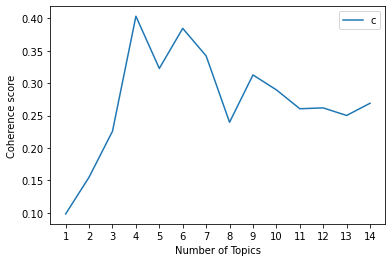

In [112]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,corpus=prepare_corpus(doc_clean)
    model_list,c_v = compute_coherence_values(dictionary, corpus, doc_clean,
                                                            stop, start, step)
  

    # cv
    x = range(start, stop, step)
    fig = plt.plot(x, c_v, label = 'cv')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(('cv'), loc='best')
    plt.xticks(ticks = x)
    plt.show()
    plt.close()

    return model_list

model_list = plot_graph(df_neg.cleaned_tweet.apply(word_tokenize),1,15,1)

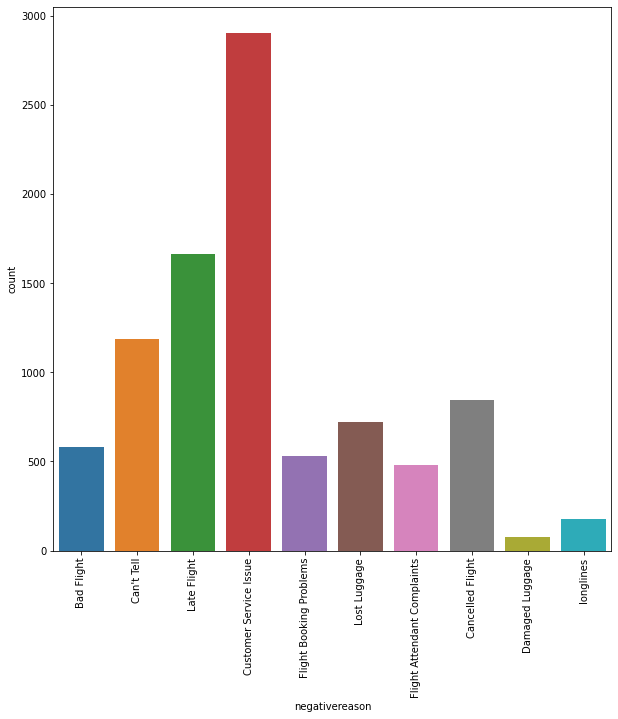

In [113]:
# Unique values of airline

plt.figure(figsize=(10,10))
ax = sns.countplot(x="negativereason", data=df_neg)
ax.tick_params(axis='x', rotation=90)

In [123]:
ntopic = 6
model = model_list[ntopic-1]
model.show_topics()

[(0,
  '-0.678*"flight" + -0.254*"cancel" + -0.161*"delay" + -0.157*"hold" + -0.138*"help" + -0.126*"time" + -0.124*"call" + -0.122*"wait" + -0.111*"service" + -0.109*"customer"'),
 (1,
  '0.508*"flight" + -0.365*"customer" + -0.364*"service" + 0.257*"cancel" + -0.229*"call" + -0.164*"wait" + -0.160*"hold" + -0.118*"bag" + -0.115*"time" + -0.112*"still"'),
 (2,
  '-0.464*"customer" + -0.462*"service" + 0.347*"hold" + 0.274*"call" + 0.190*"wait" + 0.172*"help" + -0.164*"bad" + 0.161*"minute" + -0.148*"flight" + -0.132*"ever"'),
 (3,
  '0.376*"delay" + -0.358*"hold" + 0.288*"plane" + -0.225*"cancel" + -0.225*"customer" + 0.217*"bag" + -0.216*"call" + -0.215*"service" + -0.186*"help" + 0.185*"gate"'),
 (4,
  '0.454*"hold" + -0.345*"call" + 0.312*"wait" + 0.286*"minute" + 0.265*"delay" + 0.163*"min" + -0.146*"back" + -0.145*"bag" + 0.143*"service" + -0.137*"say"'),
 (5,
  '-0.382*"call" + 0.315*"hold" + 0.286*"bad" + 0.275*"fly" + 0.268*"airline" + -0.243*"wait" + 0.237*"help" + 0.198*"eve

In [140]:
list_guess = ['Flight Cancelled',   # 0
              'Flight Customer Service',   # 1
              'CS booking',   # 2
              'Flight Delay',   # 3
              'CS booking',   # 4
              'flight epxerience']   # 5]

In [124]:
lst = []
for topic in model.show_topics(formatted=False):
    tuples = topic[1]
    for tup in tuples:
        lst.append(tup[0])

counter=pd.DataFrame(lst).value_counts()
print(counter.head(10))
#plt.show()
print('\n')

call        6
hold        6
wait        5
customer    5
service     5
help        4
bag         3
cancel      3
delay       3
flight      3
dtype: int64




### Find the most dominant topic in each document

In [125]:
corpus_transformed = model[corpus]
len(corpus_transformed)

9169

In [126]:
j=list(corpus_transformed)[0]
j[0][1]

-0.013402563499510254

In [139]:
from pandas.core.common import not_none
topic_prediction=[]
for j in list(corpus_transformed):
    if len(j) > 0:
      main_topic=j[0][0]
      weigth=np.abs(j[0][1])
      for t,w in j:
          if np.abs(w) > weigth :
              main_topic=t
              weigth=np.abs(w)
    topic_prediction.append(main_topic)

In [134]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(df_neg.negativereason))

print(le.classes_)

enc_negativereason=le.transform(list(df_neg.negativereason))

['Bad Flight' "Can't Tell" 'Cancelled Flight' 'Customer Service Issue'
 'Damaged Luggage' 'Flight Attendant Complaints' 'Flight Booking Problems'
 'Late Flight' 'Lost Luggage' 'longlines']


In [137]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(enc_negativereason,topic_prediction,normalize='pred')
print(cm)

[[0.07308216 0.01652893 0.01757188 0.10080645 0.04873294 0.06905371
  0.         0.         0.         0.        ]
 [0.10145256 0.12855831 0.06070288 0.09516129 0.16276803 0.35294118
  0.         0.         0.         0.        ]
 [0.17635043 0.00459137 0.00958466 0.01129032 0.01851852 0.03324808
  0.         0.         0.         0.        ]
 [0.21970041 0.60881543 0.80031949 0.08629032 0.4337232  0.28388747
  0.         0.         0.         0.        ]
 [0.00522015 0.01010101 0.00159744 0.01370968 0.01267057 0.01150895
  0.         0.         0.         0.        ]
 [0.05674081 0.04958678 0.02715655 0.07580645 0.02923977 0.04603581
  0.         0.         0.         0.        ]
 [0.08125284 0.02020202 0.02875399 0.00887097 0.07309942 0.05754476
  0.         0.         0.         0.        ]
 [0.21289151 0.0523416  0.03194888 0.39112903 0.08479532 0.09846547
  0.         0.         0.         0.        ]
 [0.05810259 0.07621671 0.01597444 0.17983871 0.11890838 0.03836317
  0.        

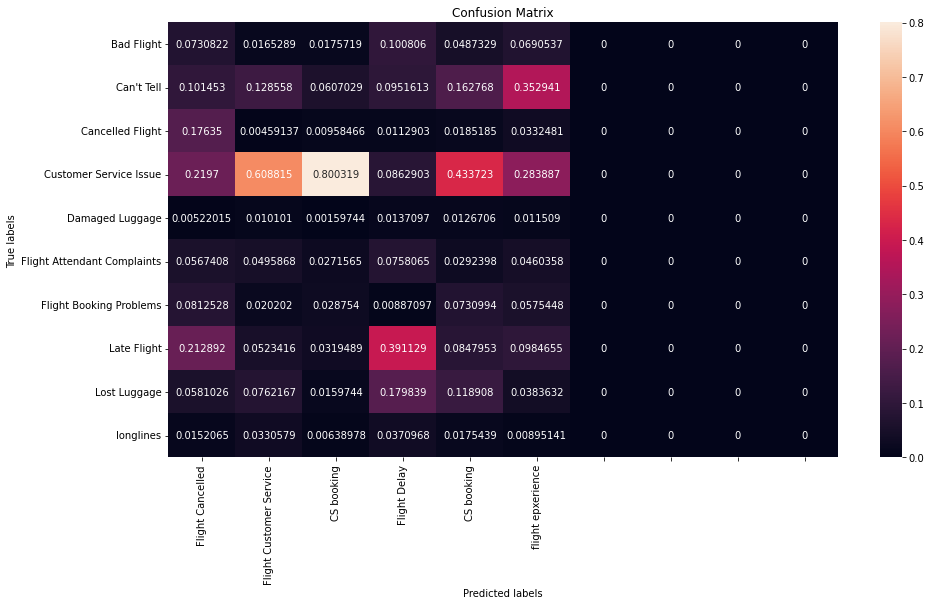

In [141]:
plt.figure(figsize = (15,8))

ax=sns.heatmap(cm, annot=True, fmt='g');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.yaxis.set_ticklabels(['Bad Flight', "Can't Tell", 'Cancelled Flight', 'Customer Service Issue',
 'Damaged Luggage', 'Flight Attendant Complaints', 'Flight Booking Problems',
 'Late Flight', 'Lost Luggage', 'longlines','nan'])
ax.tick_params(axis='y', rotation=0)
ax.xaxis.set_ticklabels(list_guess)
ax.tick_params(axis='x', rotation=90)
plt.show()
plt.close()
#plt.set_xticklabels(ax.get_xticklabels(),rotation = 30)